# U-Turn analysis on the 9-grid Gaussian mixture (analysis-only)

This notebook **does not retrain** the score network. It loads the trained model saved by  
`02-SGM-with-SDE-9grid-bis.ipynb` (copy of `02-SGM-with-SDE-9grid.ipynb` with less of overlap between modes) and runs a systematic **U-Turn** study:

1. Draw a clean sample $x_0$ from the target 9-mode Gaussian mixture.
2. Sample $x_{T_u}\sim p(x_{T_u}\mid x_0)$ using the **same forward noising SDE** as in the training notebook (VPSDE).
3. Initialize the reverse process at $y_{T_u}=x_{T_u}$ and simulate the **reverse-time SDE** down to $t=0$ using the trained score network.
4. Record $y_0$ and collect statistics as a function of $T_u$.

We focus on:
- distance drift: $\|y_0-x_0\|$ vs $T_u$;
- mode/speciation: whether $y_0$ stays in the same mixture component as $x_0$.

All figures are **saved into `figs/`**.

In [1]:
import os, math, random
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

## Reproducibility and paths

In [2]:
# ---------- reproducibility ----------
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# ---------- output directory ----------
FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)

# ---------- model checkpoint (must be present) ----------
CKPT_PATH = "trained_score_model-bis.pt"  # produced by 02-SGM-with-SDE-9grid.ipynb
if not os.path.exists(CKPT_PATH):
    raise FileNotFoundError(
        f"Missing checkpoint: {CKPT_PATH}.\n"
        "Please place the trained score network checkpoint in the same folder as this notebook.\n"
        "Expected behavior: the training notebook saves it via torch.save(..., 'trained_score_model-bis.pt')."
    )

device: cpu


## Load the trained score network (same architecture as in the training notebook)

In [3]:
# Load the trained score network saved by 02-SGM-with-SDE-9grid.ipynb.
# IMPORTANT: the network architecture here MUST match the checkpoint.
# The checkpoint we load below corresponds to a 3→64→64→64→2 MLP with LogSigmoid nonlinearity:
#   Linear(3,64) → LogSigmoid → Linear(64,64) → LogSigmoid → Linear(64,64) → LogSigmoid → Linear(64,2)

score_network = nn.Sequential(
    nn.Linear(3, 64),
    nn.LogSigmoid(),
    nn.Linear(64, 64),
    nn.LogSigmoid(),
    nn.Linear(64, 64),
    nn.LogSigmoid(),
    nn.Linear(64, 2),
).to(device)

state = torch.load(CKPT_PATH, map_location=device)
score_network.load_state_dict(state)
score_network.eval()

print("Loaded score network from:", CKPT_PATH)


Loaded score network from: trained_score_model-bis.pt


## Forward SDE: Variance-Preserving SDE (VPSDE) schedule (same as training notebook)

In [4]:
# In 02-SGM-with-SDE-9grid.ipynb:
# beta(t) = 0.1 + t*(20-0.1)
# int_beta(t) = (0.1 + 0.5*(20-0.1)*t) * t
# conditional:
#   mean = x0 * exp(-0.5*int_beta(t))
#   var  = 1 - exp(-int_beta(t))

beta_min, beta_max = 0.1, 20.0

def beta(t: torch.Tensor) -> torch.Tensor:
    return beta_min + t * (beta_max - beta_min)

def int_beta(t: torch.Tensor) -> torch.Tensor:
    return (beta_min + 0.5*(beta_max - beta_min)*t) * t

@torch.no_grad()
def sample_forward_xt(x0: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Sample x_t ~ p(x_t | x0) for VPSDE."""
    # x0: (B,2), t: (B,1) or scalar tensor
    if t.ndim == 0:
        t = t.view(1, 1).repeat(x0.shape[0], 1)
    elif t.ndim == 1:
        t = t.view(-1, 1)
    ib = int_beta(t)  # (B,1)
    mean = x0 * torch.exp(-0.5 * ib)
    var = 1.0 - torch.exp(-ib)
    eps = torch.randn_like(x0)
    return mean + torch.sqrt(var) * eps

## Target distribution: 9-mode Gaussian mixture on a 3×3 grid

In [5]:
# We use a simple 3x3 grid of centers; tune 'spacing' and 'sigma' if needed.
spacing = 6.0
centers_1d = torch.tensor([-spacing, 0.0, spacing], device=device)
grid_centers = torch.stack(
    torch.meshgrid(centers_1d, centers_1d, indexing="xy"),
    dim=-1
).reshape(-1, 2)  # (9,2)

sigma = 0.5  # component std
n_modes = grid_centers.shape[0]

@torch.no_grad()
def sample_x0(batch: int) -> torch.Tensor:
    """Sample x0 from an equally-weighted 9-mode isotropic Gaussian mixture."""
    idx = torch.randint(low=0, high=n_modes, size=(batch,), device=device)
    mu = grid_centers[idx]
    return mu + sigma * torch.randn(batch, 2, device=device), idx

@torch.no_grad()
def nearest_mode(x: torch.Tensor) -> torch.Tensor:
    """Nearest mixture center index for each x."""
    # x: (B,2)
    d2 = ((x[:, None, :] - grid_centers[None, :, :])**2).sum(dim=-1)
    return torch.argmin(d2, dim=1)

## Reverse SDE simulator (Euler–Maruyama)

In [6]:
@torch.no_grad()
def score_fn(x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
    """Score network input: [x1, x2, t]. Returns (B,2)."""
    if t.ndim == 0:
        t = t.view(1, 1).repeat(x.shape[0], 1)
    elif t.ndim == 1:
        t = t.view(-1, 1)
    inp = torch.cat([x, t], dim=1)  # (B,3)
    return score_network(inp)

@torch.no_grad()
def reverse_sde(y_Tu: torch.Tensor, Tu: float, n_steps: int = 200) -> torch.Tensor:
    """Simulate reverse SDE from t=Tu down to t=0.

    Forward VPSDE: dx = -0.5 beta(t) x dt + sqrt(beta(t)) dW
    Reverse SDE:   dy = [-0.5 beta(t) y - beta(t) score(y,t)] dt + sqrt(beta(t)) dW_rev
    Integrated with Euler–Maruyama using negative dt.

    Returns y_0 with shape (B,2).
    """
    y = y_Tu.clone()
    # time grid: Tu -> 0
    ts = torch.linspace(Tu, 0.0, n_steps+1, device=device)
    for k in range(n_steps):
        t = ts[k]
        dt = ts[k+1] - ts[k]  # negative
        b = beta(t)
        sc = score_fn(y, t)
        drift = (-0.5 * b * y) - (b * sc)
        # diffusion term uses sqrt(|dt|)
        noise = torch.randn_like(y)
        y = y + drift * dt + torch.sqrt(b) * math.sqrt(abs(float(dt))) * noise
    return y

## U-Turn experiment: sweep $T_u$ and collect diagnostics

In [7]:
@torch.no_grad()
def uturn_once(batch: int, Tu: float, n_steps: int = 200):
    """One batch of U-turn experiments at fixed Tu."""
    x0, mode0 = sample_x0(batch)
    t_tensor = torch.full((batch, 1), float(Tu), device=device)
    xTu = sample_forward_xt(x0, t_tensor)
    y0 = reverse_sde(xTu, Tu=Tu, n_steps=n_steps)

    dist = torch.linalg.norm(y0 - x0, dim=1)  # (B,)
    mode_y = nearest_mode(y0)
    same_mode = (mode_y == mode0).float()
    return {
        "x0": x0.detach().cpu().numpy(),
        "y0": y0.detach().cpu().numpy(),
        "mode0": mode0.detach().cpu().numpy(),
        "modey": mode_y.detach().cpu().numpy(),
        "dist": dist.detach().cpu().numpy(),
        "same_mode": same_mode.detach().cpu().numpy(),
    }

# sweep settings
Tu_grid = np.linspace(0.02, 1.0, 20)   # adjust as desired
BATCH = 1024
N_STEPS = 300  # reverse discretization steps

results = []
for Tu in Tu_grid:
    out = uturn_once(BATCH, float(Tu), n_steps=N_STEPS)
    results.append(out)
    print(f"Tu={Tu:0.3f}  mean||y0-x0||={out['dist'].mean():0.3f}  P(same mode)={out['same_mode'].mean():0.3f}")

Tu=0.020  mean||y0-x0||=0.132  P(same mode)=1.000
Tu=0.072  mean||y0-x0||=0.388  P(same mode)=1.000
Tu=0.123  mean||y0-x0||=0.564  P(same mode)=1.000
Tu=0.175  mean||y0-x0||=0.681  P(same mode)=0.999
Tu=0.226  mean||y0-x0||=0.775  P(same mode)=0.997
Tu=0.278  mean||y0-x0||=0.965  P(same mode)=0.964
Tu=0.329  mean||y0-x0||=1.286  P(same mode)=0.900
Tu=0.381  mean||y0-x0||=2.037  P(same mode)=0.771
Tu=0.433  mean||y0-x0||=2.773  P(same mode)=0.629
Tu=0.484  mean||y0-x0||=3.757  P(same mode)=0.487
Tu=0.536  mean||y0-x0||=5.133  P(same mode)=0.326
Tu=0.587  mean||y0-x0||=6.125  P(same mode)=0.249
Tu=0.639  mean||y0-x0||=7.157  P(same mode)=0.201
Tu=0.691  mean||y0-x0||=7.952  P(same mode)=0.146
Tu=0.742  mean||y0-x0||=8.370  P(same mode)=0.136
Tu=0.794  mean||y0-x0||=8.371  P(same mode)=0.144
Tu=0.845  mean||y0-x0||=8.564  P(same mode)=0.123
Tu=0.897  mean||y0-x0||=8.717  P(same mode)=0.110
Tu=0.948  mean||y0-x0||=8.701  P(same mode)=0.126
Tu=1.000  mean||y0-x0||=9.083  P(same mode)=0.101


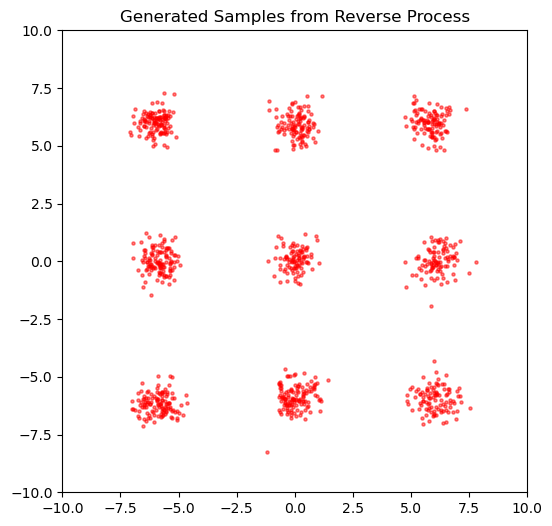

In [12]:
# 🔄 Reverse Process (Sampling) -- visual sanity check for the fully trained model -- that samples are generated correctly
# ------------------------------
def generate_samples(score_network: torch.nn.Module, nsamples: int) -> torch.Tensor:
    x_t = torch.randn((nsamples, 2))  
    time_pts = torch.linspace(1, 0, 1000)
    beta = lambda t: 0.1 + (20 - 0.1) * t

    for i in range(len(time_pts) - 1):
        t = time_pts[i]
        dt = time_pts[i + 1] - t
        fxt = -0.5 * beta(t) * x_t
        gt = beta(t) ** 0.5
        score = score_network(torch.cat((x_t, t.expand(x_t.shape[0], 1)), dim=-1)).detach()
        drift = fxt - gt * gt * score
        diffusion = gt
        x_t = x_t + drift * dt + diffusion * torch.randn_like(x_t) * torch.abs(dt) ** 0.5

    return x_t

# Generate and plot synthetic samples
samples = generate_samples(score_network, 1000).detach()
plt.figure(figsize=(6, 6))
plt.scatter(samples[:, 0], samples[:, 1], s=5, alpha=0.5, color='red')
plt.xlim(-10, 10)
plt.ylim(-10, 10)
plt.title("Generated Samples from Reverse Process")
plt.savefig('figs/sbd_9grid_generated_only-bis.png', dpi=200, bbox_inches='tight')
plt.show()

## Mean distance $\mathbb{E}[\|y_0-x_0\|]$ and mode-retention probability vs $T_u$

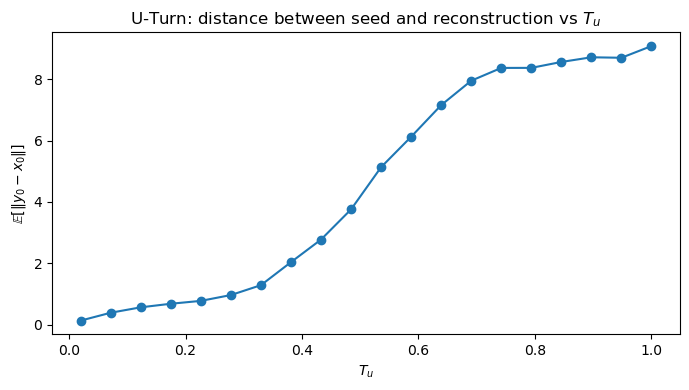

saved: figs/uturn_mean_distance_vs_Tu.png


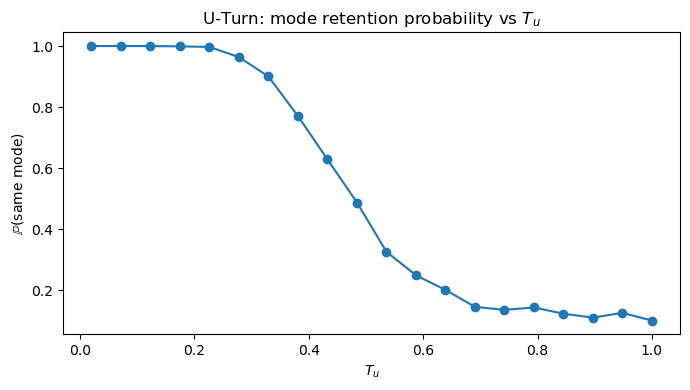

saved: figs/uturn_mode_retention_vs_Tu.png


In [8]:
mean_dist = np.array([r["dist"].mean() for r in results])
p_same = np.array([r["same_mode"].mean() for r in results])

plt.figure(figsize=(7,4))
plt.plot(Tu_grid, mean_dist, marker="o")
plt.xlabel(r"$T_u$")
plt.ylabel(r"$\mathbb{E}[\|y_0-x_0\|]$")
plt.title("U-Turn: distance between seed and reconstruction vs $T_u$")
plt.tight_layout()
out1 = os.path.join(FIG_DIR, "uturn_mean_distance_vs_Tu.png")
plt.savefig(out1, dpi=200)
plt.show()
print("saved:", out1)

plt.figure(figsize=(7,4))
plt.plot(Tu_grid, p_same, marker="o")
plt.xlabel(r"$T_u$")
plt.ylabel(r"$\mathbb{P}(\text{same mode})$")
plt.title("U-Turn: mode retention probability vs $T_u$")
plt.tight_layout()
out2 = os.path.join(FIG_DIR, "uturn_mode_retention_vs_Tu.png")
plt.savefig(out2, dpi=200)
plt.show()
print("saved:", out2)

## Distribution of distances across $T_u$ (quantiles)

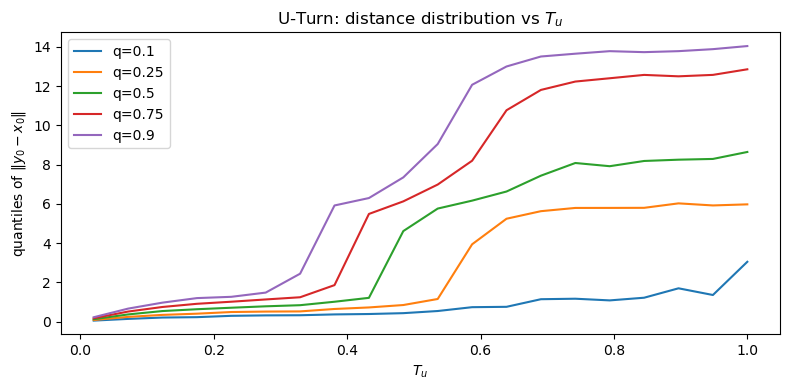

saved: figs/uturn_distance_quantiles_vs_Tu.png


In [10]:
# summarize distributions by quantiles
qs = [0.1, 0.25, 0.5, 0.75, 0.9]
qvals = np.array([[np.quantile(r["dist"], q) for q in qs] for r in results])

plt.figure(figsize=(8,4))
for j,q in enumerate(qs):
    plt.plot(Tu_grid, qvals[:,j], label=f"q={q}")
plt.xlabel(r"$T_u$")
plt.ylabel(r"quantiles of $\|y_0-x_0\|$")
plt.title("U-Turn: distance distribution vs $T_u$")
plt.legend()
plt.tight_layout()
out3 = os.path.join(FIG_DIR, "uturn_distance_quantiles_vs_Tu.png")
plt.savefig(out3, dpi=200)
plt.show()
print("saved:", out3)

## Additional diagnostic: speciation matrix between modes

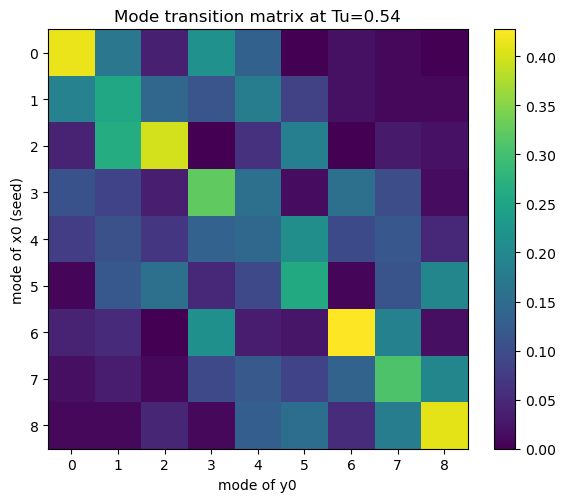

saved: figs/uturn_mode_transition_matrix_Tu_0.54.png


In [11]:
# confusion-like matrix: P(mode_y = j | mode0 = i), aggregated over Tu (or pick a Tu index)
Tu_idx = len(Tu_grid)//2  # middle Tu as a representative snapshot
r = results[Tu_idx]
m0 = r["mode0"]
my = r["modey"]

conf = np.zeros((n_modes, n_modes), dtype=float)
for i in range(n_modes):
    mask = (m0 == i)
    if mask.sum() == 0:
        continue
    for j in range(n_modes):
        conf[i,j] = np.mean(my[mask] == j)

plt.figure(figsize=(6,5))
plt.imshow(conf, aspect="equal")
plt.colorbar()
plt.xlabel("mode of y0")
plt.ylabel("mode of x0 (seed)")
plt.title(f"Mode transition matrix at Tu={Tu_grid[Tu_idx]:0.2f}")
plt.tight_layout()
out4 = os.path.join(FIG_DIR, f"uturn_mode_transition_matrix_Tu_{Tu_grid[Tu_idx]:0.2f}.png")
plt.savefig(out4, dpi=200)
plt.show()
print("saved:", out4)

## More on the speciation transition 

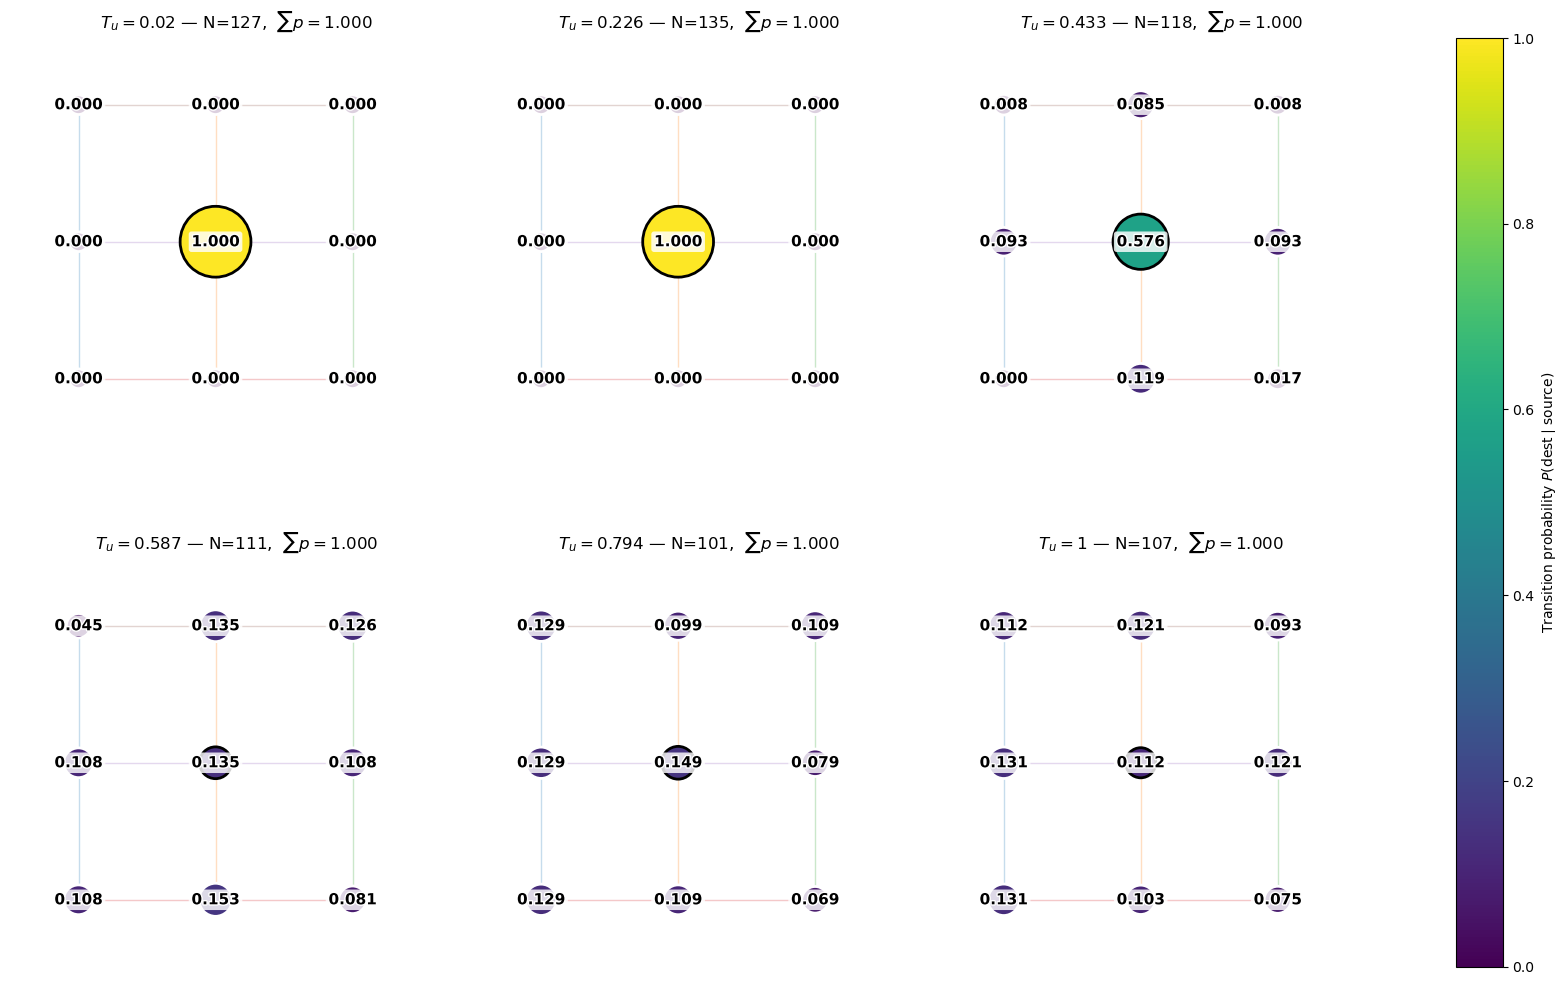

Saved: figs/uturn_speciation_from_center_checked.png
Checked: sizes are strictly monotone with probabilities in every panel (no inversions detected).


In [22]:
# --- U-Turn: speciation visualization with hard size/probability consistency checks ---
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)

# ---------------- User settings ----------------
Tu_list_to_plot = None             # None -> auto-pick up to 6 panels
source_xy = np.array([0.0, 0.0])   # choose source mode nearest to (0,0)

# Marker AREA in points^2 (scatter's s)
s_min, s_max = 200, 2600
use_size_encoding = True

cmap_name = "viridis"
cmap = plt.get_cmap(cmap_name)
vmin, vmax = 0.0, 1.0

annotate_min_p = 0.00              # set to 0.03 if you want less clutter
annotate_fmt = "{:.3f}"            # show 3 decimals to reduce rounding ambiguity

out_path = os.path.join(FIG_DIR, "uturn_speciation_from_center_checked.png")

# ---------------- Required notebook variables ----------------
# Tu_grid, results, n_modes, grid_centers must already exist

grid_centers_np = (
    grid_centers.detach().cpu().numpy()
    if hasattr(grid_centers, "detach")
    else np.asarray(grid_centers)
)
Tu_grid_np = np.asarray(Tu_grid, dtype=float)

# Source mode index (closest to source_xy)
source_idx = int(np.argmin(((grid_centers_np - source_xy[None, :]) ** 2).sum(axis=1)))

# ---------------- Build 3×3 layout from centers ----------------
x_vals = np.sort(np.unique(grid_centers_np[:, 0]))
y_vals = np.sort(np.unique(grid_centers_np[:, 1]))
if len(x_vals) != 3 or len(y_vals) != 3:
    raise ValueError(f"Expected 3 unique x and y values for a 3x3 grid; got {len(x_vals)} x and {len(y_vals)} y.")

idx_to_rc = {}
for j, (xj, yj) in enumerate(grid_centers_np):
    col = int(np.where(x_vals == xj)[0][0])
    row_bottom = int(np.where(y_vals == yj)[0][0])  # 0 = lowest y
    row = 2 - row_bottom                            # 0 = top
    idx_to_rc[j] = (row, col)

node_xy = {(r, c): (c, 2 - r) for r in range(3) for c in range(3)}

# Precompute node positions in order j=0..n_modes-1
xs = np.zeros(n_modes)
ys = np.zeros(n_modes)
for j in range(n_modes):
    r, c = idx_to_rc[j]
    xs[j], ys[j] = node_xy[(r, c)]

# ---------------- Choose T_u panels ----------------
if Tu_list_to_plot is None:
    n_panels_default = min(6, len(Tu_grid_np))
    idxs = np.linspace(0, len(Tu_grid_np) - 1, n_panels_default).round().astype(int).tolist()
else:
    idxs = [int(np.argmin(np.abs(Tu_grid_np - float(Tu)))) for Tu in Tu_list_to_plot]
idxs = list(dict.fromkeys(idxs))

# ---------------- Size mapping: AREA ∝ p ----------------
def prob_to_s(p):
    p = float(np.clip(p, 0.0, 1.0))
    if not use_size_encoding:
        return 900.0
    return s_min + (s_max - s_min) * p  # strictly increasing in p

def check_inversions(probs, sizes, tol=1e-12):
    # Flags any pair (i,j) with p_i < p_j but s_i > s_j (beyond tol)
    inv = []
    for i in range(len(probs)):
        for j in range(len(probs)):
            if probs[i] + tol < probs[j] and sizes[i] > sizes[j] + tol:
                inv.append((i, j, probs[i], probs[j], sizes[i], sizes[j]))
    return inv

# ---------------- Plot ----------------
n_panels = len(idxs)
ncols = min(3, n_panels)
nrows = int(np.ceil(n_panels / ncols))

fig, axes = plt.subplots(
    nrows, ncols,
    figsize=(5.2 * ncols, 5.2 * nrows),
    constrained_layout=True
)
if nrows * ncols == 1:
    axes = np.array([axes])
axes = axes.ravel()

sm = plt.cm.ScalarMappable(cmap=cmap)
sm.set_clim(vmin, vmax)

any_inversion = False

for a, k in enumerate(idxs):
    ax = axes[a]
    Tu = float(Tu_grid_np[k])

    m0 = np.asarray(results[k]["mode0"], dtype=int)
    my = np.asarray(results[k]["modey"], dtype=int)

    mask = (m0 == source_idx)
    denom = int(mask.sum())

    if denom == 0:
        ax.set_title(rf"$T_u={Tu:.3g}$ — N=0", fontsize=12)
        ax.text(1.0, 1.0, "No trajectories\nfrom source mode",
                ha="center", va="center", fontsize=14, weight="bold")
        probs = np.zeros(n_modes, dtype=float)
    else:
        counts = np.bincount(my[mask], minlength=n_modes).astype(float)
        probs = counts / float(denom)
        probs = probs / probs.sum()  # exact normalization
        ax.set_title(rf"$T_u={Tu:.3g}$ — N={denom},  $\sum p={probs.sum():.3f}$", fontsize=12)

    colors = cmap((probs - vmin) / (vmax - vmin + 1e-12))
    sizes = np.array([prob_to_s(p) for p in probs], dtype=float)

    inv = check_inversions(probs, sizes)
    if len(inv) > 0:
        any_inversion = True
        ax.text(1.0, 2.25, "SIZE/PROB INVERSION DETECTED",
                ha="center", va="center", fontsize=10, weight="bold",
                bbox=dict(facecolor="white", alpha=0.9, edgecolor="red"))
        # Also print one example to console
        i, j, pi, pj, si, sj = inv[0]
        print(f"[WARNING] Tu={Tu:.6g}: inversion example i={i}, j={j}: "
              f"p_i={pi:.6f} < p_j={pj:.6f} but s_i={si:.2f} > s_j={sj:.2f}")

    # grid lines
    for x in [0, 1, 2]:
        ax.plot([x, x], [0, 2], lw=1, alpha=0.25, zorder=0)
    for y in [0, 1, 2]:
        ax.plot([0, 2], [y, y], lw=1, alpha=0.25, zorder=0)

    # edge colors: black for source, white for others (same linewidth; NO size overlay)
    edgecols = np.array(["white"] * n_modes, dtype=object)
    edgecols[source_idx] = "black"

    ax.scatter(xs, ys, s=sizes, c=colors, edgecolors=edgecols, linewidths=2.0, zorder=2)

    # annotations (exactly the same probs used for sizes)
    if denom > 0:
        for j in range(n_modes):
            p = float(probs[j])
            if p < annotate_min_p:
                continue
            t = ax.text(xs[j], ys[j], annotate_fmt.format(p),
                        ha="center", va="center", fontsize=11, weight="bold",
                        bbox=dict(boxstyle="round,pad=0.18", facecolor="white", edgecolor="none", alpha=0.82),
                        zorder=3)
            t.set_path_effects([pe.withStroke(linewidth=2, foreground="white")])

    ax.set_xlim(-0.5, 2.8)
    ax.set_ylim(-0.5, 2.5)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_frame_on(False)

# disable unused axes
for t in range(n_panels, nrows * ncols):
    axes[t].axis("off")

cbar = fig.colorbar(sm, ax=axes[:n_panels], shrink=0.9, location="right")
cbar.set_label(r"Transition probability $P(\mathrm{dest}\mid \mathrm{source})$")

fig.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()
print("Saved:", out_path)

if not any_inversion:
    print("Checked: sizes are strictly monotone with probabilities in every panel (no inversions detected).")
else:
    print("At least one panel reported an inversion; see console warning(s).")


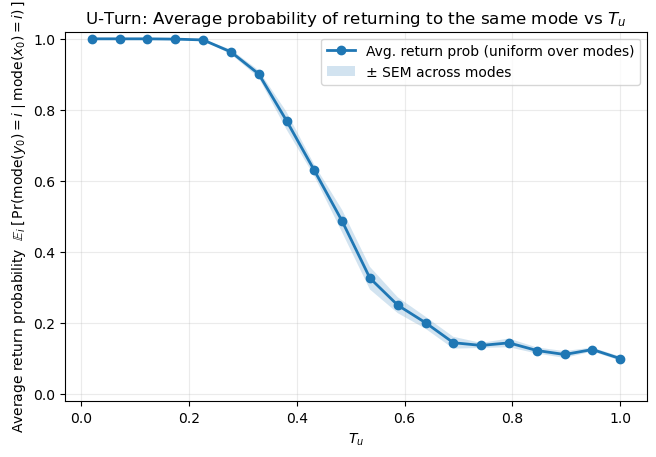

Saved: figs/uturn_avg_return_prob_vs_Tu.png
Min samples per mode across Tu (useful sanity check):
[(0.02, 95), (0.07157894736842105, 86), (0.1231578947368421, 92), (0.17473684210526313, 97), (0.2263157894736842, 96), (0.27789473684210525, 92), (0.3294736842105263, 104), (0.38105263157894737, 93), (0.4326315789473684, 96), (0.4842105263157895, 101)] ...


In [23]:
# --- U-Turn diagnostic: average "return-to-same-mode" probability vs T_u ---
import os
import numpy as np
import matplotlib.pyplot as plt

FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)

# Requires from your notebook:
#   Tu_grid : array-like of T_u values
#   results : list of dicts; each results[k] has 'mode0' and 'modey'
#   n_modes : int (9)

Tu_grid_np = np.asarray(Tu_grid, dtype=float)

avg_return = np.zeros(len(Tu_grid_np), dtype=float)
per_mode_return = np.full((len(Tu_grid_np), n_modes), np.nan, dtype=float)
counts_per_mode = np.zeros((len(Tu_grid_np), n_modes), dtype=int)

for k, Tu in enumerate(Tu_grid_np):
    m0 = np.asarray(results[k]["mode0"], dtype=int)
    my = np.asarray(results[k]["modey"], dtype=int)

    # per-mode return probability: P(modey == mode0 | mode0 = i)
    for i in range(n_modes):
        mask = (m0 == i)
        denom = int(mask.sum())
        counts_per_mode[k, i] = denom
        if denom > 0:
            per_mode_return[k, i] = float(np.mean(my[mask] == i))

    # average across modes (uniform over modes), ignoring modes with 0 samples
    valid = np.isfinite(per_mode_return[k, :])
    if np.any(valid):
        avg_return[k] = float(np.mean(per_mode_return[k, valid]))
    else:
        avg_return[k] = np.nan

# Sort by Tu (in case Tu_grid isn't sorted)
order = np.argsort(Tu_grid_np)
Tu_sorted = Tu_grid_np[order]
avg_sorted = avg_return[order]
per_mode_sorted = per_mode_return[order, :]
counts_sorted = counts_per_mode[order, :]

# Optional: compute an error bar proxy (SEM over modes, not over trajectories)
# (Useful to visualize heterogeneity across modes.)
mode_sem = np.full_like(avg_sorted, np.nan, dtype=float)
for k in range(len(Tu_sorted)):
    vals = per_mode_sorted[k, :]
    vals = vals[np.isfinite(vals)]
    if len(vals) >= 2:
        mode_sem[k] = np.std(vals, ddof=1) / np.sqrt(len(vals))

# Plot
fig, ax = plt.subplots(figsize=(7.5, 4.8))

ax.plot(Tu_sorted, avg_sorted, marker="o", linewidth=2, label="Avg. return prob (uniform over modes)")

# Light uncertainty band (across modes); comment out if you want a cleaner plot
if np.any(np.isfinite(mode_sem)):
    ax.fill_between(Tu_sorted, avg_sorted - mode_sem, avg_sorted + mode_sem, alpha=0.2, label="± SEM across modes")

ax.set_xlabel(r"$T_u$")
ax.set_ylabel(r"Average return probability  $\mathbb{E}_i\,[\,\Pr(\mathrm{mode}(y_0)=i\mid \mathrm{mode}(x_0)=i)\,]$")
ax.set_title("U-Turn: Average probability of returning to the same mode vs $T_u$")
ax.set_ylim(-0.02, 1.02)
ax.grid(True, alpha=0.25)
ax.legend(loc="best")

out_path = os.path.join(FIG_DIR, "uturn_avg_return_prob_vs_Tu.png")
fig.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", out_path)

# Optional diagnostics: report if some modes are under-sampled at any Tu
min_counts = counts_sorted.min(axis=1)
print("Min samples per mode across Tu (useful sanity check):")
print(list(zip(Tu_sorted[:10], min_counts[:10])), "..." if len(Tu_sorted) > 10 else "")


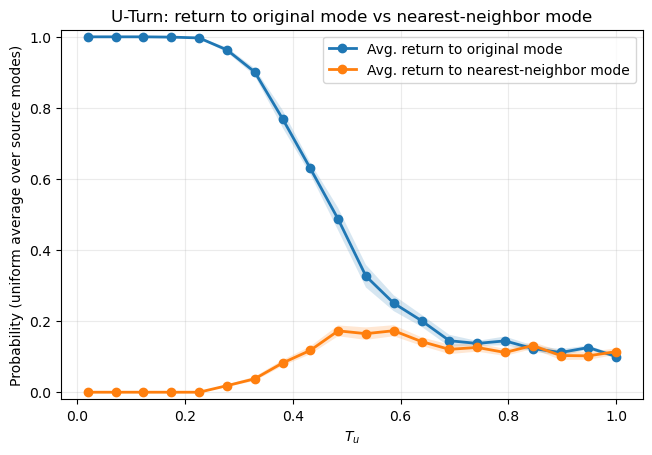

Saved: figs/uturn_return_same_vs_neighbor_vs_Tu.png
Neighbor definition: nearest distinct mode center for each source mode.


In [24]:
# --- U-Turn diagnostic: avg return-to-same-mode vs avg return-to-neighbor-mode (as functions of T_u) ---
import os
import numpy as np
import matplotlib.pyplot as plt

FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)

# Requires from your notebook:
#   Tu_grid : array-like of T_u values
#   results : list of dicts; each results[k] has 'mode0' and 'modey'
#   n_modes : int (9)
#   grid_centers : (9,2) tensor/array of mode centers

Tu_grid_np = np.asarray(Tu_grid, dtype=float)
centers = grid_centers.detach().cpu().numpy() if hasattr(grid_centers, "detach") else np.asarray(grid_centers)

# --- define "neighbor mode" as the nearest *distinct* center (by Euclidean distance) ---
# neighbor_idx[i] = argmin_{j != i} ||mu_i - mu_j||
d2 = ((centers[:, None, :] - centers[None, :, :]) ** 2).sum(axis=2)
np.fill_diagonal(d2, np.inf)
neighbor_idx = np.argmin(d2, axis=1)  # (n_modes,)

avg_same = np.zeros(len(Tu_grid_np), dtype=float)
avg_neighbor = np.zeros(len(Tu_grid_np), dtype=float)

per_mode_same = np.full((len(Tu_grid_np), n_modes), np.nan, dtype=float)
per_mode_neighbor = np.full((len(Tu_grid_np), n_modes), np.nan, dtype=float)

counts_per_mode = np.zeros((len(Tu_grid_np), n_modes), dtype=int)

for k, Tu in enumerate(Tu_grid_np):
    m0 = np.asarray(results[k]["mode0"], dtype=int)
    my = np.asarray(results[k]["modey"], dtype=int)

    for i in range(n_modes):
        mask = (m0 == i)
        denom = int(mask.sum())
        counts_per_mode[k, i] = denom
        if denom == 0:
            continue

        per_mode_same[k, i] = float(np.mean(my[mask] == i))
        nb = int(neighbor_idx[i])
        per_mode_neighbor[k, i] = float(np.mean(my[mask] == nb))

    # uniform average over modes that have samples
    valid = np.isfinite(per_mode_same[k, :])
    if np.any(valid):
        avg_same[k] = float(np.mean(per_mode_same[k, valid]))
        avg_neighbor[k] = float(np.mean(per_mode_neighbor[k, valid]))
    else:
        avg_same[k] = np.nan
        avg_neighbor[k] = np.nan

# Sort by Tu (in case Tu_grid isn't sorted)
order = np.argsort(Tu_grid_np)
Tu_sorted = Tu_grid_np[order]
same_sorted = avg_same[order]
nb_sorted = avg_neighbor[order]

# Optional: SEM across modes (heterogeneity visualization)
def sem_across_modes(arr_k):
    vals = arr_k[np.isfinite(arr_k)]
    if len(vals) >= 2:
        return np.std(vals, ddof=1) / np.sqrt(len(vals))
    return np.nan

same_sem = np.array([sem_across_modes(per_mode_same[order][k, :]) for k in range(len(Tu_sorted))])
nb_sem   = np.array([sem_across_modes(per_mode_neighbor[order][k, :]) for k in range(len(Tu_sorted))])

# Plot
fig, ax = plt.subplots(figsize=(7.5, 4.8))

ax.plot(Tu_sorted, same_sorted, marker="o", linewidth=2,
        label="Avg. return to original mode")
ax.plot(Tu_sorted, nb_sorted, marker="o", linewidth=2,
        label="Avg. return to nearest-neighbor mode")

# Light SEM bands (comment out for a cleaner plot)
if np.any(np.isfinite(same_sem)):
    ax.fill_between(Tu_sorted, same_sorted - same_sem, same_sorted + same_sem, alpha=0.18)
if np.any(np.isfinite(nb_sem)):
    ax.fill_between(Tu_sorted, nb_sorted - nb_sem, nb_sorted + nb_sem, alpha=0.18)

ax.set_xlabel(r"$T_u$")
ax.set_ylabel("Probability (uniform average over source modes)")
ax.set_title("U-Turn: return to original mode vs nearest-neighbor mode")
ax.set_ylim(-0.02, 1.02)
ax.grid(True, alpha=0.25)
ax.legend(loc="best")

out_path = os.path.join(FIG_DIR, "uturn_return_same_vs_neighbor_vs_Tu.png")
fig.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", out_path)
print("Neighbor definition: nearest distinct mode center for each source mode.")


## Notes on additional diagnostics (ideas)

If you want more “phase-transition-like” signatures on this toy problem, two useful additions are:

1. **Autocorrelation**: estimate $\mathbb{E}[x_0^\top y_0]$ (or cosine similarity) vs $T_u$; it often shows a sharper change than Euclidean distance.
2. **Energy / log-density proxy**: since the target is a mixture with known density, you can evaluate $\log p_{\text{target}}(y_0)$ vs $T_u$ and look for sharp changes.
3. **Pathwise divergence**: store a few full reverse trajectories and compute the time at which trajectories from the same seed begin to separate.

These are straightforward extensions of the functions above.